About the project
- This project seeks to develop through machine learning a model for detecting fraudulent financial transactions that is high-performance. Inside the dataset is simulated transaction data from a 30-day period. A major issue is the extreme class disparity. It is less than 0.1% of all of the data that consists of fraudulent transactions. A model must be built in order to precisely recognize rare fraudulent cases while minimizing any false alarms.

- Methodology and Approach
Here’s how I approached the problem:

- Exploratory Data Analysis (EDA):
The first step was to analyze the dataset. Interestingly, all fraudulent activity was confined to just two types of transactions: TRANSFER and CASH_OUT. This discovery shaped much of the modeling strategy going forward.

- Feature Engineering:
To help the model make better predictions, I created several new features. First, I used one-hot encoding for the categorical “type” column. I also engineered two new features—errorBalanceOrig and errorBalanceDest—which measure discrepancies in account balances before and after each transaction. These turned out to be strong clues for detecting fraud.

- Handling Class Imbalance:
Given how rare fraudulent transactions are, I used SMOTE (Synthetic Minority Oversampling Technique) to create a more balanced training set. This resampling was done only on the training data to prevent any accidental data leakage.

- Modeling and Evaluation:
For the actual model, I chose the XGBoost Classifier, known for its speed and strong performance. Once trained on the balanced dataset, I tested it using the held-out data. Instead of just looking at accuracy, I focused on metrics that matter for rare events: precision and recall, measured using a confusion matrix. The final model was able to correctly identify about 92% of fraudulent transactions, showing that this approach can make a real difference for fraud detection.



In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('Fraud.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [13]:
df.shape

(124456, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124457 entries, 0 to 124456
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            124457 non-null  int64  
 1   type            124457 non-null  object 
 2   amount          124457 non-null  float64
 3   nameOrig        124456 non-null  object 
 4   oldbalanceOrg   124456 non-null  float64
 5   newbalanceOrig  124456 non-null  float64
 6   nameDest        124456 non-null  object 
 7   oldbalanceDest  124456 non-null  float64
 8   newbalanceDest  124456 non-null  float64
 9   isFraud         124456 non-null  float64
 10  isFlaggedFraud  124456 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 10.4+ MB


In [5]:
df.isna().sum()

,0
step,0
type,0
amount,0
nameOrig,1
oldbalanceOrg,1
newbalanceOrig,1
nameDest,1
oldbalanceDest,1
newbalanceDest,1
isFraud,1


In [6]:
df.dropna(inplace = True)

In [7]:
df.isna().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [9]:
df[df.duplicated()]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [10]:
df['type'].value_counts()

,count
type,
PAYMENT,48078
CASH_OUT,39349
CASH_IN,25208
TRANSFER,10650
DEBIT,1171


In [11]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,124456.000000,1.244560e+05,1.244560e+05,1.244560e+05,1.244560e+05,1.244560e+05,124456.000000,124456.0
mean,8.920928,1.773621e+05,9.047501e+05,9.209941e+05,9.004621e+05,1.185246e+06,0.000964,0.0
std,1.857026,3.440316e+05,2.850751e+06,2.887776e+06,2.391423e+06,2.749984e+06,0.031037,0.0
min,1.000000,3.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,8.000000,1.059714e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,9.000000,5.785164e+04,2.009300e+04,0.000000e+00,2.830632e+04,7.527365e+04,0.000000,0.0
75%,10.000000,2.180577e+05,1.952794e+05,2.222311e+05,6.424462e+05,1.097218e+06,0.000000,0.0
max,11.000000,1.000000e+07,3.893942e+07,3.894623e+07,3.400874e+07,3.894623e+07,1.000000,0.0


In [14]:
# Insights-
# What I see is that the data is highly skewed by a very large transactions
# Data is also really imbalance since the amount of fraud is extremely low
# also I'm dropping the feature isFlaggedFraud since every value present in that is 0
# Next step will be is to find where the fraud is actually occuring


In [15]:
df.groupby('type')['isFraud'].sum()
# so fraud only occurs ub TRANSFER AND CASH_OUT

,isFraud
type,
CASH_IN,0.0
CASH_OUT,61.0
DEBIT,0.0
PAYMENT,0.0
TRANSFER,59.0


In [17]:
# also dropping the features which are not useful with The ML model I'm building
df = df.drop(['isFlaggedFraud','nameOrig','nameDest'], axis =1)

### Feature Engineering & PreProcessing


In [20]:
# Ok, I'll create the new error based-features
# How this will work?
# For a normal transaction, these "error" features should be very close to zero. For a fraudulent one, they might be wildly different,
# making them incredibly powerful predictors.
df['errorBalanceOrig']=df['newbalanceOrig']+ df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest']+df['amount'] - df['newbalanceDest']

In [23]:
# One-Hot encoding
X = pd.get_dummies(df, columns=['type'], prefix = 'type', drop_first=True)

In [24]:
y = X['isFraud']
X = X.drop('isFraud', axis=1)

In [25]:
print('Shape of X:', X.shape)
print("Shape of y:", y.shape)
X.head()

Shape of X: (124456, 12)
Shape of y: (124456,)


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0.0,9839.64,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0.0,1864.28,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,0.0,181.00,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,0.0,21363.00,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0.0,11668.14,False,False,True,False


### Model Training

In [28]:
# standard 80-20 split
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size = 0.2, random_state=42, stratify =y
)

print('Shape of X_train before SMOTE:', X_train.shape)

Shape of X_train before SMOTE: (99564, 12)


In [29]:
# Since there's an imbalance I'm using SMOTE( Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# and standard rule for smote- only apply on train data never test data
print('Shape of X_train after SMOTE:', X_train_smote.shape)

Shape of X_train after SMOTE: (198936, 12)


In [30]:
model = XGBClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)
print("Model training Completed")

Model training Completed


### Model Evaluation and Performance

In [ ]:
# will you confusion matrix to evaluate

In [32]:
y_pred = model.predict(X_test)

In [33]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n         0.0       1.00      1.00      1.00     24868\n         1.0       0.76      0.92      0.83        24\n\n    accuracy                           1.00     24892\n   macro avg       0.88      0.96      0.92     24892\nweighted avg       1.00      1.00      1.00     24892\n'

In [36]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[24861     7]
 [    2    22]]


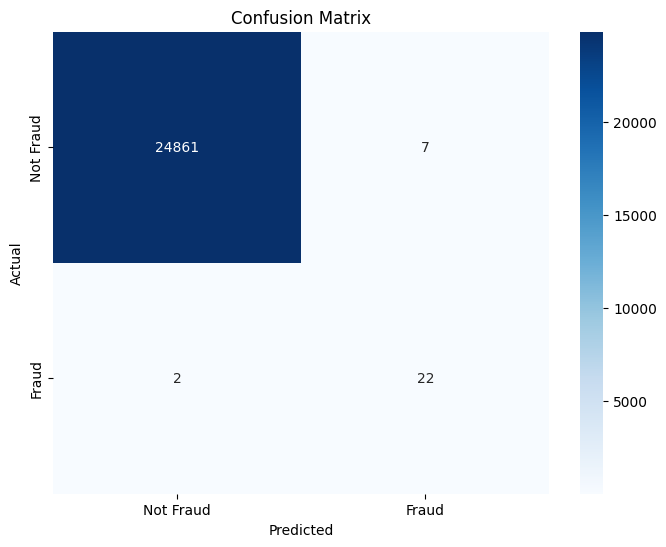

In [37]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Ok the model is showing amazing result, YAY!